<a href="https://colab.research.google.com/github/lee4106/ML_Final/blob/main/50024_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import the packages**

In [1]:
!pip install higher
import numpy as np
import pandas as pd
import higher
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import itertools
from tqdm.notebook import tqdm
from torch import autograd




Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Fuctions to generate imbalanced train datasets, balanced test dataset and clean dataset**

In [2]:
args = {'batch_size':100, 'lr':0.001, 'n_epochs':100, 'device':torch.device("cuda" if torch.cuda.is_available() else "cpu")}

In [3]:
def get_clean_dataset(testset, set_size = 0.002):
  #split cat and dog datasets
  train_cat_idxs = np.where(np.array(testset.targets) == 3)[0] 
  train_dog_idxs = np.where(np.array(testset.targets) == 5)[0] 
  total_cats = len(train_cat_idxs) #5000
  total_dogs = len(train_dog_idxs) #5000
  num_of_cats = int(total_cats*set_size)
  num_of_dogs = int(total_dogs*set_size)
  #clean data set
  clean_idxs = np.concatenate([train_cat_idxs[:num_of_cats], train_dog_idxs[:num_of_dogs]])
  clean_dataset = torch.utils.data.Subset(testset,clean_idxs)
  clean_loader = torch.utils.data.DataLoader(clean_dataset, batch_size=args['batch_size'], shuffle=True, num_workers=2)
  return clean_loader
def get_imbalanced_datasets(trainset,imbalance_ratio):  #ratio = cats/dogs
  #split cat and dog datasets
  train_cat_idxs = np.where(np.array(trainset.targets) == 3)[0] 
  train_dog_idxs = np.where(np.array(trainset.targets) == 5)[0] 
  total_cats = len(train_cat_idxs) #5000
  total_dogs = len(train_dog_idxs) #5000
  #Imbalanced dataset
  num_of_cats = int(total_cats*imbalance_ratio)
  imbl_train_idxs = np.concatenate([train_cat_idxs[:num_of_cats], train_dog_idxs[:total_dogs]])
  imbl_train_dataset = torch.utils.data.Subset(trainset,imbl_train_idxs)
  data_loader = torch.utils.data.DataLoader(imbl_train_dataset, batch_size=args['batch_size'], shuffle=True, num_workers=2)
  return data_loader

def get_balanced_datasets(testset):
  test_cat_idxs = np.where(np.array(testset.targets) == 3)[0] 
  test_dog_idxs = np.where(np.array(testset.targets) == 5)[0]   
  total_cats = len(test_cat_idxs) #5000
  total_dogs = len(test_dog_idxs) #5000
  #balanced dataset
  test_idxs = np.concatenate([test_cat_idxs[:total_cats], test_dog_idxs[:total_dogs]])
  test_dataset = torch.utils.data.Subset(testset,test_idxs)
  data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args['batch_size'], shuffle=True, num_workers=2)
  return data_loader



# **Helper Functions**

In [4]:
class LeNet5(torch.nn.Module):          
    def __init__(self):     
        super(LeNet5, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=2, bias=True)
        self.max_pool_1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0, bias=True)
        self.max_pool_2 = torch.nn.MaxPool2d(kernel_size=2) 
        self.fc1 = torch.nn.Linear(16*6*6, 120)   
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, 6)
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))  
        x = self.max_pool_1(x) 
        x = torch.nn.functional.relu(self.conv2(x))
        x = self.max_pool_2(x)
        x = x.view(-1, 16*6*6)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x).squeeze()
        return x

In [5]:
def accuracy(network, dataloader):
  network.eval()
  total_correct = 0
  total_instances = 0
  for  _, (images, labels) in enumerate(dataloader):
    images, labels = images.to(device = args['device'], non_blocking=True), labels.to(device = args['device'], non_blocking=True)
    predictions = torch.argmax(network(images), dim=1)
    correct_predictions = sum(predictions==labels).item()
    total_correct+=correct_predictions
    total_instances+=len(images)
  return round(total_correct/total_instances, 3)

In [6]:

def train_base_model(model, criterion, optimizer, train_loader):
  loss_track = []
  accuracy_track = []
  for i in tqdm(range(1, args['n_epochs']+1)):
    model.train()
    accu = 0
    loss = 0
    correct = 0
    sum = 0
    for _, (images, labels) in enumerate(train_loader):
      images,labels = images.to(device = args['device'], non_blocking=True),labels.to(device = args['device'], non_blocking=True)
      outputs = model(images)
      optimizer.zero_grad()
      training_loss = criterion(outputs, labels)
      training_loss.backward()
      optimizer.step()
      loss += training_loss.item()*outputs.shape[0]
    loss_track.append(loss/(len(train_loader)*100))
    
    #evaluating
    model.eval()
    with torch.no_grad():
        train_accu = accuracy(model, train_loader)
        accuracy_track.append(train_accu)
    print('Training Loss:', loss/(len(train_loader)*100), 'Training Accuracy:', train_accu)
  return loss_track, accuracy_track




In [7]:
def base_model(model, criterion, optimizer, train_loader, test_loader):
  train_loss_track = []
  train_accuracy_track = []
  test_loss_track = []
  test_accuracy_track = []
  for i in tqdm(range(1, args['n_epochs']+1)):
    model.train()
    tr_accu = 0
    accu = 0
    tr_loss = 0
    loss = 0
    correct = 0
    sum = 0
    for _, (images, labels) in enumerate(train_loader):
      images,labels = images.to(device = args['device'], non_blocking=True),labels.to(device = args['device'], non_blocking=True)
      outputs = model(images)
      optimizer.zero_grad()
      training_loss = criterion(outputs, labels)
      training_loss.backward()
      optimizer.step()
      loss += training_loss.item()*outputs.shape[0]
      _, predicted = torch.max(outputs.data, 1)
      correct += predicted.eq(labels.data).cpu().sum()
    tr_loss = loss/len(train_loader.dataset)
    tr_accu = correct.numpy() / len(train_loader.dataset)
    train_loss_track.append(tr_loss)
    train_accuracy_track.append(tr_accu)
    
    #Test evaluating
    model.eval()
    criterion.reduction = 'mean'
    running_loss = 0.0
    correct = 0
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device = args['device']), targets.to(device = args['device'])
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * outputs.shape[0]
            _, predicted = torch.max(outputs.data, 1)
            correct += predicted.eq(targets.data).cpu().sum()
    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_acc = correct.numpy() / len(test_loader.dataset)
    test_loss_track.append(epoch_loss)
    test_accuracy_track.append(epoch_acc)
    print('Training Loss:', tr_loss, 'Training Accuracy:', tr_accu,'Testing Loss:', epoch_loss, 'Testing Accuracy:', epoch_acc)
  return train_loss_track, train_accuracy_track, test_loss_track, test_accuracy_track


In [8]:

def train_model_reweighting(model, criterion, optimizer, train_loader, clean_loader):
    loss_track = []
    accuracy_track = []
    for i in tqdm(range(1, args['n_epochs']+1)):
        model.train()
        loss = 0
        # Step 2: Sample mini-batch from Df
        for _, (images,labels) in enumerate(train_loader):
          images,labels = images.to(device = args['device'], non_blocking=True),labels.to(device = args['device'], non_blocking=True)
          optimizer.zero_grad()
          
          with higher.innerloop_ctx(model, optimizer) as (clean_model, clean_optimizer):
            # Step 1. Update meta model on training data
            ctrain_outputs = clean_model(images)
            criterion.reduction = 'none'
            ctrain_loss = criterion(ctrain_outputs, labels)
            eps = torch.zeros(ctrain_loss.size(), requires_grad=True, device=args['device'])
            ctrain_loss = torch.sum(eps * ctrain_loss)
            clean_optimizer.step(ctrain_loss)

            # Step 2. Compute grads of eps on meta validation data
            clean_images, clean_labels =  next(clean_loader)
            #meta_labels =meta_labels.unsqueeze(1)  
            clean_images, clean_labels = clean_images.to(device=args['device'], non_blocking=True),\
                            clean_labels.to(device=args['device'], non_blocking=True)

            clean_val_outputs = clean_model(clean_images)
            criterion.reduction = 'mean'
            clean_val_loss = criterion(clean_val_outputs, clean_labels)
            eps_grads = torch.autograd.grad(clean_val_loss, eps)[0].detach()
          # Step 3:
          w_hat = torch.clamp(-eps_grads, min = 0)
          sum = torch.sum(w_hat)
          if (sum == 0):
            weight = w_hat
          else:
            weight = w_hat/sum

          # Step 4: Forward pass on Xf with current theta
          y_hat_f = model(images)
          criterion.reduction = 'none'
          mloss = criterion(y_hat_f, labels)
          minib_loss = torch.sum(mloss*weight)

          optimizer.zero_grad()
          minib_loss.backward()
          optimizer.step()

          loss += minib_loss.item()*y_hat_f.shape[0]
        loss_track.append(loss/(len(train_loader)*100))
        model.eval()
        with torch.no_grad():
          train_accu = accuracy(model, train_loader)
          accuracy_track.append(train_accu)
        print('Training Loss:', loss/(len(train_loader)*100), 'Training Accuracy:', train_accu)
    return loss_track, accuracy_track

In [9]:
def model_reweighting(model, criterion, optimizer, train_loader, clean_loader, test_loader):
      train_loss_track = []
      train_accuracy_track = []
      test_loss_track = []
      test_accuracy_track = []
      for i in tqdm(range(1, args['n_epochs']+1)):
        model.train()
        tr_accu = 0
        accu = 0
        tr_loss = 0
        loss = 0
        correct = 0
        sum = 0
        # Step 2: Sample mini-batch from Df
        for _, (images,labels) in enumerate(train_loader):
          images,labels = images.to(device = args['device'], non_blocking=True),labels.to(device = args['device'], non_blocking=True)
          optimizer.zero_grad()
          
          with higher.innerloop_ctx(model, optimizer) as (clean_model, clean_optimizer):
            # Step 1. Update meta model on training data
            ctrain_outputs = clean_model(images)
            criterion.reduction = 'none'
            ctrain_loss = criterion(ctrain_outputs, labels)
            eps = torch.zeros(ctrain_loss.size(), requires_grad=True, device=args['device'])
            ctrain_loss = torch.sum(eps * ctrain_loss)
            clean_optimizer.step(ctrain_loss)

            # Step 2. Compute grads of eps on meta validation data
            clean_images, clean_labels =  next(clean_loader)
            #meta_labels =meta_labels.unsqueeze(1)  
            clean_images, clean_labels = clean_images.to(device=args['device'], non_blocking=True),\
                            clean_labels.to(device=args['device'], non_blocking=True)

            clean_val_outputs = clean_model(clean_images)
            criterion.reduction = 'mean'
            clean_val_loss = criterion(clean_val_outputs, clean_labels)
            eps_grads = torch.autograd.grad(clean_val_loss, eps)[0].detach()
          # Step 3:
          w_hat = torch.clamp(-eps_grads, min = 0)
          sum = torch.sum(w_hat)
          if (sum == 0):
            weight = w_hat
          else:
            weight = w_hat/sum


          y_hat_f = model(images)
          criterion.reduction = 'none'
          mloss = criterion(y_hat_f, labels)
          minib_loss = torch.sum(mloss*weight)

          optimizer.zero_grad()
          minib_loss.backward()
          optimizer.step()

          loss += minib_loss.item()*y_hat_f.shape[0]
          _, predicted = torch.max(y_hat_f.data, 1)
          correct += predicted.eq(labels.data).cpu().sum()
        tr_loss = loss/len(train_loader.dataset)
        tr_accu = correct.numpy() / len(train_loader.dataset)
        train_loss_track.append(tr_loss)
        train_accuracy_track.append(tr_accu)
        
        #Test evaluating
        model.eval()
        criterion.reduction = 'mean'
        running_loss = 0.0
        correct = 0
        with torch.no_grad():
            for i, (inputs, targets) in enumerate(test_loader):
                inputs, targets = inputs.to(device = args['device']), targets.to(device = args['device'])
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                running_loss += loss.item() * outputs.shape[0]
                _, predicted = torch.max(outputs.data, 1)
                correct += predicted.eq(targets.data).cpu().sum()
        epoch_loss = running_loss / len(test_loader.dataset)
        epoch_acc = correct.numpy() / len(test_loader.dataset)
        test_loss_track.append(epoch_loss)
        test_accuracy_track.append(epoch_acc)
        print('Training Loss:', tr_loss, 'Training Accuracy:', tr_accu,'Testing Loss:', epoch_loss, 'Testing Accuracy:', epoch_acc)
      return train_loss_track, train_accuracy_track, test_loss_track, test_accuracy_track

In [10]:
def test_model0(model, criterion, test_loader):
    test_loss_hist = []
    test_accu_hist = []
    total = 0
    for i in tqdm(range(1, args['n_epochs']+1)):
      model.eval()  # Set the model to evaluation mode
      loss = 0

      correct = 0
      with torch.no_grad():
          for  _, (images,labels) in enumerate(test_loader):
            images,labels = images.to(device = args['device']),labels.to(device = args['device'])
            predict = model(images)
            testing_loss = criterion(predict, labels)
            loss += testing_loss.item() * predict.shape[0]
            _, predicted = torch.max(predict.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
      test_loss_hist.append(loss/len(test_loader))
      #test_accu = accuracy(model, test_loader)
      test_accu_hist.append(correct/len(test_loader))

      print('Training Loss:', loss/len(test_loader), 'Training Accuracy:', correct/len(test_loader))
    return test_loss_hist, test_accu_hist

In [11]:
def test_model(model, criterion, test_loader):
  loss_track = []
  accuracy_track = []
  for i in tqdm(range(1, args['n_epochs']+1)):
    model.train()
    accu = 0
    loss = 0
    correct = 0
    sum = 0
    for _, (images, labels) in enumerate(test_loader):
      images,labels = images.to(device = args['device'], non_blocking=True),labels.to(device = args['device'], non_blocking=True)
      outputs = model(images)
      training_loss = criterion(outputs, labels)
      training_loss.backward()
      loss += training_loss.item()*outputs.shape[0]
    loss_track.append(loss/(len(test_loader)*100))
    model.eval()
    with torch.no_grad():
        train_accu = accuracy(model, test_loader)
        accuracy_track.append(train_accu)
    print('Testing Loss:', loss/(len(test_loader)*100), 'Testing Accuracy:', train_accu)
  return loss_track, accuracy_track

## **Main**

Laoding the datasets and split it

In [12]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = args['batch_size']
#load the train dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

#load train dataset, imbalanced dataset
imbl_train_loader  = get_imbalanced_datasets(trainset, 0.995)

#load the test dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = get_balanced_datasets(testset)


100%|██████████| 170498071/170498071 [00:04<00:00, 40591987.89it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Training a base model

In [13]:
model = LeNet5()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=args['lr'])

#training baseline
#loss_hist, accu_hist = train_base_model(model, criterion, optimizer, imbl_train_loader)
bs_tr_loss_hist, bs_tr_accu_hist, bs_ts_loss_hist, bs_ts_accu_hist = base_model(model, criterion, optimizer, imbl_train_loader, test_loader)


  0%|          | 0/100 [00:00<?, ?it/s]

Training Loss: 1.7042266190201418 Training Accuracy: 0.4523308270676692 Testing Loss: 1.671844834089279 Testing Accuracy: 0.5045
Training Loss: 1.6391423919744659 Training Accuracy: 0.4863157894736842 Testing Loss: 1.6039521276950837 Testing Accuracy: 0.506
Training Loss: 1.5659108415880896 Training Accuracy: 0.4917293233082707 Testing Loss: 1.5229954421520233 Testing Accuracy: 0.503
Training Loss: 1.4704029772215916 Training Accuracy: 0.49724310776942354 Testing Loss: 1.4064444839954375 Testing Accuracy: 0.501
Training Loss: 1.315939465859779 Training Accuracy: 0.49834586466165415 Testing Loss: 1.2035250186920166 Testing Accuracy: 0.5005
Training Loss: 1.0701364036789514 Training Accuracy: 0.49894736842105264 Testing Loss: 0.9399717062711715 Testing Accuracy: 0.501
Training Loss: 0.85732220497944 Training Accuracy: 0.4986466165413534 Testing Loss: 0.7952285587787629 Testing Accuracy: 0.516
Training Loss: 0.7656247266253134 Training Accuracy: 0.5157894736842106 Testing Loss: 0.74250108

Training a reweight model

In [14]:
#traning reweight model
rw_model = LeNet5()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(rw_model.parameters(), lr=args['lr'])
#load train dataset, imbalanced dataset
imbl_train_loader  = get_imbalanced_datasets(trainset, 0.995)

#load the test dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = get_balanced_datasets(testset)

#load clean data set
clean_loader = get_clean_dataset(trainset)
clean_loader = itertools.cycle(clean_loader)
#load test data set
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = get_balanced_datasets(testset)
#traning
rw_tr_loss_hist, rw_tr_accu_hist, rw_ts_loss_hist, rw_ts_accu_hist = model_reweighting(rw_model, criterion, optimizer, imbl_train_loader, clean_loader, test_loader)

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/100 [00:00<?, ?it/s]

Training Loss: 1.7379067894211389 Training Accuracy: 0.4498245614035088 Testing Loss: 1.7130883038043976 Testing Accuracy: 0.5
Training Loss: 1.6906796481675075 Training Accuracy: 0.5012531328320802 Testing Loss: 1.6671264886856079 Testing Accuracy: 0.5005
Training Loss: 1.6454537993385678 Training Accuracy: 0.5023558897243108 Testing Loss: 1.6229232966899871 Testing Accuracy: 0.499
Training Loss: 1.6017410029146009 Training Accuracy: 0.5030576441102756 Testing Loss: 1.5799249589443207 Testing Accuracy: 0.49
Training Loss: 1.5589493883582284 Training Accuracy: 0.5029573934837093 Testing Loss: 1.537556654214859 Testing Accuracy: 0.508
Training Loss: 1.516336659142248 Training Accuracy: 0.5141854636591479 Testing Loss: 1.4948756635189056 Testing Accuracy: 0.541
Training Loss: 1.4725088394972914 Training Accuracy: 0.5156892230576441 Testing Loss: 1.4501925230026245 Testing Accuracy: 0.52
Training Loss: 1.4249470637256938 Training Accuracy: 0.5035588972431078 Testing Loss: 1.40039153695106

Plot the figures

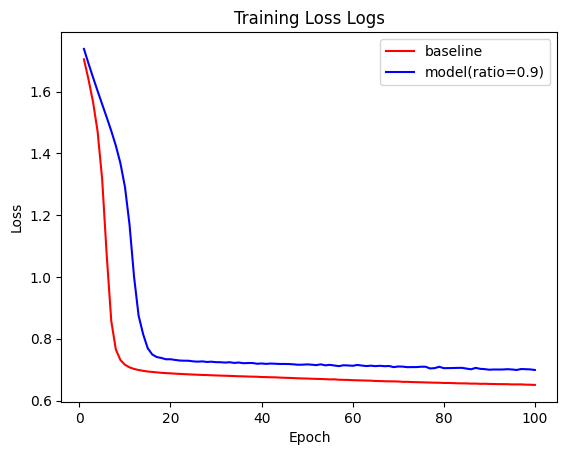

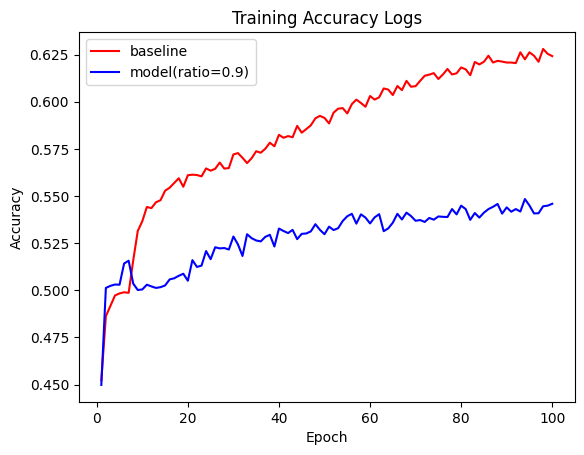

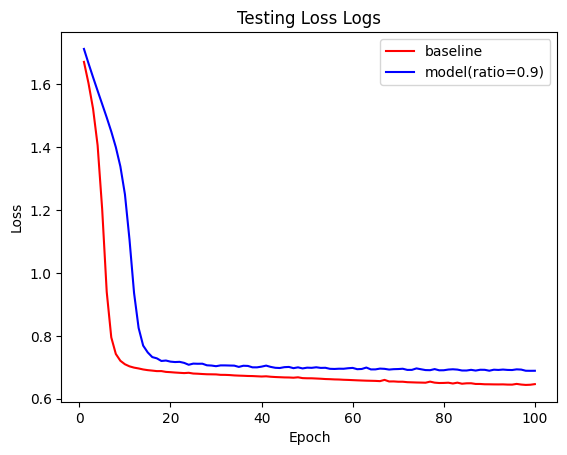

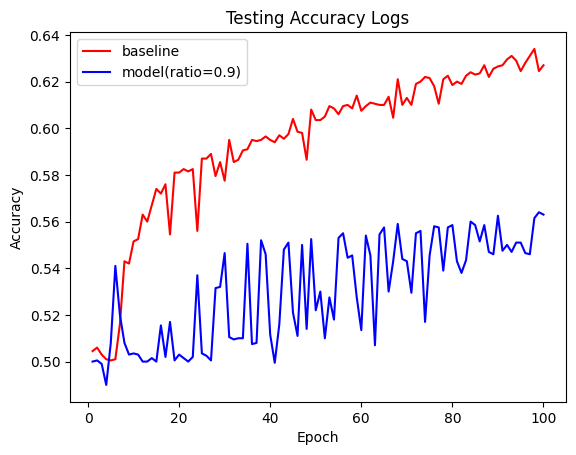

In [15]:
#trainning logs--------------------------------------------
# Plot the loss history
rg = np.linspace(1,len(bs_tr_loss_hist),len(bs_tr_loss_hist))
plt.plot(rg, bs_tr_loss_hist, 'r', label='baseline')
plt.plot(rg, rw_tr_loss_hist, 'b', label='model(ratio=0.9)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Logs')
plt.legend()
plt.show()

# Plot the accuracy history
rg = np.linspace(1,len(bs_tr_accu_hist),len(bs_tr_accu_hist))
plt.plot(rg, bs_tr_accu_hist, 'r', label='baseline')
plt.plot(rg, rw_tr_accu_hist, 'b', label='model(ratio=0.9)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Logs')
plt.legend()
plt.show()

#Testing logs----------------------------------------------
# Plot the loss history
rg = np.linspace(1,len(bs_ts_loss_hist),len(bs_ts_loss_hist))
plt.plot(rg, bs_ts_loss_hist, 'r', label='baseline')
plt.plot(rg, rw_ts_loss_hist, 'b', label='model(ratio=0.9)')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.title('Testing Loss Logs')
plt.legend()
plt.show()

# Plot the accuracy history
rg = np.linspace(1,len(bs_ts_accu_hist),len(bs_ts_accu_hist))
plt.plot(rg, bs_ts_accu_hist, 'r', label='baseline')
plt.plot(rg, rw_ts_accu_hist, 'b', label='model(ratio=0.9)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Testing Accuracy Logs')
plt.legend()
plt.show()

Train models on different imbalanced ratio dataset

In [16]:
args = {'batch_size':100, 'lr':0.006, 'n_epochs':15, 'device':torch.device("cuda" if torch.cuda.is_available() else "cpu")}
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = args['batch_size']
#load the train dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

ratios = [0.9, 0.95, 0.98, 0.99, 0.995]

base_accu = []
rw_accu = []
for r in ratios:
  #load train dataset, imbalanced dataset
  imbl_train_loader  = get_imbalanced_datasets(trainset, r)

  #load the test dataset
  test_loader = get_balanced_datasets(testset)

  #define model
  model = LeNet5()
  criterion = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=args['lr'])

  #training baseline
  bs_tr_loss_hist, bs_tr_accu_hist, bs_ts_loss_hist, bs_ts_accu_hist = base_model(model, criterion, optimizer, imbl_train_loader, test_loader)

  base_accu.append(sum(bs_ts_accu_hist)/len(bs_ts_accu_hist))  #store avg base accu

  #train rewright model
  rw_model = LeNet5()
  rw_criterion = torch.nn.CrossEntropyLoss()
  rw_optimizer = torch.optim.SGD(rw_model.parameters(), lr=args['lr'])
  #load clean data set
  clean_loader = get_clean_dataset(trainset)
  clean_loader = itertools.cycle(clean_loader)
  #load test data set
  testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
  test_loader = get_balanced_datasets(testset)
  #traning
  rw_tr_loss_hist, rw_tr_accu_hist, rw_ts_loss_hist, rw_ts_accu_hist = model_reweighting(rw_model, rw_criterion, rw_optimizer, imbl_train_loader, clean_loader, test_loader)

  rw_accu.append(sum(rw_ts_accu_hist)/len(rw_ts_accu_hist))  #store avg base accu


Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/15 [00:00<?, ?it/s]

Training Loss: 1.6672050061978791 Training Accuracy: 0.4765263157894737 Testing Loss: 1.541263747215271 Testing Accuracy: 0.5
Training Loss: 1.3524533497659783 Training Accuracy: 0.5263157894736842 Testing Loss: 1.059271514415741 Testing Accuracy: 0.5
Training Loss: 0.8032150199538783 Training Accuracy: 0.5296842105263158 Testing Loss: 0.7167389512062072 Testing Accuracy: 0.528
Training Loss: 0.7044300838520653 Training Accuracy: 0.5372631578947369 Testing Loss: 0.6983779758214951 Testing Accuracy: 0.5215
Training Loss: 0.6953142285346985 Training Accuracy: 0.5373684210526316 Testing Loss: 0.6935940533876419 Testing Accuracy: 0.5285
Training Loss: 0.6915885385714079 Training Accuracy: 0.5450526315789473 Testing Loss: 0.6897189050912857 Testing Accuracy: 0.539
Training Loss: 0.6892109808168914 Training Accuracy: 0.5556842105263158 Testing Loss: 0.6856709659099579 Testing Accuracy: 0.558
Training Loss: 0.6876191114124499 Training Accuracy: 0.543578947368421 Testing Loss: 0.68562201559543

  0%|          | 0/15 [00:00<?, ?it/s]

Training Loss: 1.6716408252716064 Training Accuracy: 0.4614736842105263 Testing Loss: 1.5522272169589997 Testing Accuracy: 0.5
Training Loss: 1.4366535876926623 Training Accuracy: 0.47421052631578947 Testing Loss: 1.29437615275383 Testing Accuracy: 0.506
Training Loss: 1.0137413802899813 Training Accuracy: 0.5083157894736842 Testing Loss: 0.7515651524066925 Testing Accuracy: 0.4995
Training Loss: 0.8115923279210141 Training Accuracy: 0.4978947368421053 Testing Loss: 0.7222829788923264 Testing Accuracy: 0.5
Training Loss: 0.7947301933639928 Training Accuracy: 0.5025263157894737 Testing Loss: 0.713009974360466 Testing Accuracy: 0.5
Training Loss: 0.7826586121007015 Training Accuracy: 0.5018947368421053 Testing Loss: 0.7117799878120422 Testing Accuracy: 0.5
Training Loss: 0.7737360308044835 Training Accuracy: 0.5042105263157894 Testing Loss: 0.7068307876586915 Testing Accuracy: 0.5
Training Loss: 0.7674887500311199 Training Accuracy: 0.5018947368421053 Testing Loss: 0.7069483369588851 Tes

  0%|          | 0/15 [00:00<?, ?it/s]

Training Loss: 1.6025650806916065 Training Accuracy: 0.4681025641025641 Testing Loss: 1.4485975086688996 Testing Accuracy: 0.5
Training Loss: 1.1180347717725314 Training Accuracy: 0.5057435897435898 Testing Loss: 0.7574166893959046 Testing Accuracy: 0.5
Training Loss: 0.7152615596086551 Training Accuracy: 0.5126153846153846 Testing Loss: 0.700368657708168 Testing Accuracy: 0.5265
Training Loss: 0.6971958848146292 Training Accuracy: 0.5245128205128206 Testing Loss: 0.6961613088846207 Testing Accuracy: 0.5
Training Loss: 0.6936799581234272 Training Accuracy: 0.5256410256410257 Testing Loss: 0.6909159481525421 Testing Accuracy: 0.5355
Training Loss: 0.690186657049717 Training Accuracy: 0.5313846153846153 Testing Loss: 0.6880923718214035 Testing Accuracy: 0.573
Training Loss: 0.6888255253816262 Training Accuracy: 0.5543589743589744 Testing Loss: 0.687182167172432 Testing Accuracy: 0.507
Training Loss: 0.6868926922480265 Training Accuracy: 0.5566153846153846 Testing Loss: 0.6864294707775116

  0%|          | 0/15 [00:00<?, ?it/s]

Training Loss: 1.5903841538306995 Training Accuracy: 0.49312820512820515 Testing Loss: 1.4268167436122894 Testing Accuracy: 0.5
Training Loss: 1.0390218753081102 Training Accuracy: 0.5089230769230769 Testing Loss: 0.7653158903121948 Testing Accuracy: 0.5
Training Loss: 0.8410579143426358 Training Accuracy: 0.49025641025641026 Testing Loss: 0.7327494204044342 Testing Accuracy: 0.508
Training Loss: 0.8097980187489436 Training Accuracy: 0.5014358974358974 Testing Loss: 0.7207910001277924 Testing Accuracy: 0.5015
Training Loss: 0.7906105741476401 Training Accuracy: 0.49958974358974356 Testing Loss: 0.7173033624887466 Testing Accuracy: 0.5
Training Loss: 0.7792444733472971 Training Accuracy: 0.49876923076923074 Testing Loss: 0.712127286195755 Testing Accuracy: 0.5
Training Loss: 0.7710784001228137 Training Accuracy: 0.4996923076923077 Testing Loss: 0.7085041970014572 Testing Accuracy: 0.5
Training Loss: 0.7658842636988713 Training Accuracy: 0.5108717948717949 Testing Loss: 0.706136533617973

  0%|          | 0/15 [00:00<?, ?it/s]

Training Loss: 1.6526764245948407 Training Accuracy: 0.494949494949495 Testing Loss: 1.5424817264080048 Testing Accuracy: 0.5
Training Loss: 1.4300036334028148 Training Accuracy: 0.494949494949495 Testing Loss: 1.2830989956855774 Testing Accuracy: 0.5
Training Loss: 0.9537633115595038 Training Accuracy: 0.49262626262626263 Testing Loss: 0.7329787671566009 Testing Accuracy: 0.512
Training Loss: 0.7124317643618343 Training Accuracy: 0.5067676767676768 Testing Loss: 0.7030382364988327 Testing Accuracy: 0.5015
Training Loss: 0.6982174262855992 Training Accuracy: 0.5188888888888888 Testing Loss: 0.6945225477218628 Testing Accuracy: 0.5475
Training Loss: 0.6950588443062522 Training Accuracy: 0.5195959595959596 Testing Loss: 0.6928851813077926 Testing Accuracy: 0.5245
Training Loss: 0.6921682219312648 Training Accuracy: 0.5362626262626262 Testing Loss: 0.6913341909646988 Testing Accuracy: 0.519
Training Loss: 0.6905339926180213 Training Accuracy: 0.5402020202020202 Testing Loss: 0.69091220200

  0%|          | 0/15 [00:00<?, ?it/s]

Training Loss: 1.6688606401886603 Training Accuracy: 0.4805050505050505 Testing Loss: 1.5107854783535004 Testing Accuracy: 0.5
Training Loss: 1.1117526051974056 Training Accuracy: 0.5097979797979798 Testing Loss: 0.7651294022798538 Testing Accuracy: 0.4965
Training Loss: 0.8304219546944204 Training Accuracy: 0.5015151515151515 Testing Loss: 0.7367038011550904 Testing Accuracy: 0.5
Training Loss: 0.8040681222472528 Training Accuracy: 0.5031313131313131 Testing Loss: 0.7212388694286347 Testing Accuracy: 0.4985
Training Loss: 0.7870110249278521 Training Accuracy: 0.49818181818181817 Testing Loss: 0.717490154504776 Testing Accuracy: 0.5
Training Loss: 0.7766916095608413 Training Accuracy: 0.49717171717171715 Testing Loss: 0.7109994292259216 Testing Accuracy: 0.501
Training Loss: 0.7687675218389491 Training Accuracy: 0.49464646464646467 Testing Loss: 0.7098977774381637 Testing Accuracy: 0.5
Training Loss: 0.763508059761741 Training Accuracy: 0.49797979797979797 Testing Loss: 0.7068850338459

  0%|          | 0/15 [00:00<?, ?it/s]

Training Loss: 1.6131465974165566 Training Accuracy: 0.45437185929648244 Testing Loss: 1.43636794090271 Testing Accuracy: 0.501
Training Loss: 1.042368745084983 Training Accuracy: 0.49547738693467336 Testing Loss: 0.7465908944606781 Testing Accuracy: 0.498
Training Loss: 0.7178518520527749 Training Accuracy: 0.5142713567839196 Testing Loss: 0.7030831575393677 Testing Accuracy: 0.5405
Training Loss: 0.699466154503463 Training Accuracy: 0.5244221105527638 Testing Loss: 0.693976816534996 Testing Accuracy: 0.5505
Training Loss: 0.6945948528884044 Training Accuracy: 0.5330653266331659 Testing Loss: 0.6999708503484726 Testing Accuracy: 0.505
Training Loss: 0.690860441282167 Training Accuracy: 0.550251256281407 Testing Loss: 0.6941310554742813 Testing Accuracy: 0.513
Training Loss: 0.6893485889362929 Training Accuracy: 0.5448241206030151 Testing Loss: 0.6915663212537766 Testing Accuracy: 0.54
Training Loss: 0.6897747600497912 Training Accuracy: 0.5412060301507537 Testing Loss: 0.6994807064533

  0%|          | 0/15 [00:00<?, ?it/s]

Training Loss: 1.7277964281676403 Training Accuracy: 0.34854271356783917 Testing Loss: 1.591634488105774 Testing Accuracy: 0.5
Training Loss: 1.3687620097069284 Training Accuracy: 0.4909547738693467 Testing Loss: 0.9518761336803436 Testing Accuracy: 0.5
Training Loss: 0.8481880606119357 Training Accuracy: 0.5046231155778894 Testing Loss: 0.7435741186141968 Testing Accuracy: 0.5
Training Loss: 0.8125602090778064 Training Accuracy: 0.4958793969849246 Testing Loss: 0.7269835919141769 Testing Accuracy: 0.5
Training Loss: 0.7912166597855151 Training Accuracy: 0.4928643216080402 Testing Loss: 0.7164607346057892 Testing Accuracy: 0.5
Training Loss: 0.7782370534973528 Training Accuracy: 0.5023115577889448 Testing Loss: 0.7120142430067062 Testing Accuracy: 0.5
Training Loss: 0.7702783948213012 Training Accuracy: 0.5007035175879397 Testing Loss: 0.7092638522386551 Testing Accuracy: 0.5
Training Loss: 0.7639984311769955 Training Accuracy: 0.4992964824120603 Testing Loss: 0.7070308804512024 Testin

  0%|          | 0/15 [00:00<?, ?it/s]

Training Loss: 1.7460245829178278 Training Accuracy: 0.2943358395989975 Testing Loss: 1.6099387288093567 Testing Accuracy: 0.5
Training Loss: 1.432036012037655 Training Accuracy: 0.49874686716791977 Testing Loss: 1.1060328304767608 Testing Accuracy: 0.5
Training Loss: 0.8069346197565695 Training Accuracy: 0.49734335839599 Testing Loss: 0.7157416075468064 Testing Accuracy: 0.5035
Training Loss: 0.7054045524513513 Training Accuracy: 0.5093734335839599 Testing Loss: 0.6985368221998215 Testing Accuracy: 0.5185
Training Loss: 0.6965976234964261 Training Accuracy: 0.5229072681704261 Testing Loss: 0.6950800895690918 Testing Accuracy: 0.5195
Training Loss: 0.6934837404647866 Training Accuracy: 0.5284210526315789 Testing Loss: 0.6891077220439911 Testing Accuracy: 0.5555
Training Loss: 0.6904277885169313 Training Accuracy: 0.5433583959899749 Testing Loss: 0.6864082634449005 Testing Accuracy: 0.557
Training Loss: 0.6894905608997011 Training Accuracy: 0.5333333333333333 Testing Loss: 0.68339229822

  0%|          | 0/15 [00:00<?, ?it/s]

Training Loss: 1.65943469798057 Training Accuracy: 0.4683709273182957 Testing Loss: 1.5341179192066192 Testing Accuracy: 0.5155
Training Loss: 1.3715268982980484 Training Accuracy: 0.5001503759398497 Testing Loss: 1.0896089315414428 Testing Accuracy: 0.5
Training Loss: 0.867893920357066 Training Accuracy: 0.49583959899749375 Testing Loss: 0.7383893311023713 Testing Accuracy: 0.5
Training Loss: 0.8105745526184713 Training Accuracy: 0.4944360902255639 Testing Loss: 0.7217546343803406 Testing Accuracy: 0.5
Training Loss: 0.7906806047697713 Training Accuracy: 0.4982456140350877 Testing Loss: 0.7144152045249939 Testing Accuracy: 0.5
Training Loss: 0.778046861477663 Training Accuracy: 0.4988471177944862 Testing Loss: 0.7109615713357925 Testing Accuracy: 0.5
Training Loss: 0.7706219697357121 Training Accuracy: 0.5041604010025063 Testing Loss: 0.7071894764900207 Testing Accuracy: 0.5
Training Loss: 0.7641601241322089 Training Accuracy: 0.5023558897243108 Testing Loss: 0.7062250316143036 Testin

Plot the figure

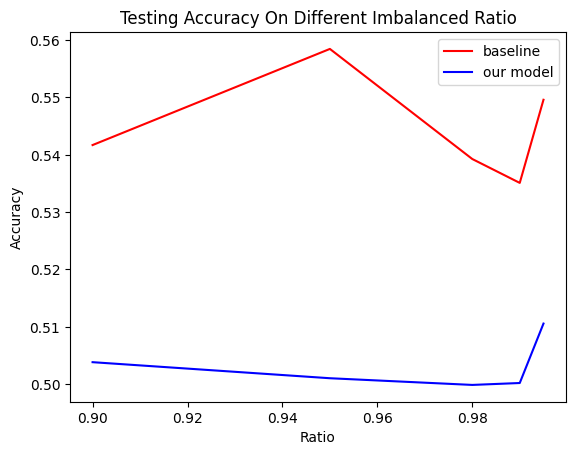

In [17]:
#plotting the result

plt.plot(ratios, base_accu, 'r', label='baseline')
plt.plot(ratios, rw_accu, 'b', label='our model')
plt.xlabel('Ratio')
plt.ylabel('Accuracy')
plt.title('Testing Accuracy On Different Imbalanced Ratio')
plt.legend()
plt.show()